In [1]:
import os
import numpy as np

In [2]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [3]:
import tensorflow as tf

2024-03-20 01:34:48.873982: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 01:34:48.875180: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 01:34:48.930499: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 01:34:49.207321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 01:34:50.046255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [4]:
N = 4

# Lendo o DataSet
## Treinamento

In [5]:
def read_graph(filepath):
    with open(filepath, "r") as f:
        line = ''

        # Parse number of vertices
        while 'DIMENSION' not in line: 
            line = f.readline()
        n = int(line.split()[1])
        Ma = np.zeros((N, N), dtype=int)
        
        # Parse edges
        while 'EDGE_DATA_SECTION' not in line: 
            line = f.readline()
        line = f.readline()
        while '-1' not in line:
            i, j = [int(x) for x in line.split()]
            Ma[i - 1, j - 1] = 1  # Subtrai 1 para ajustar para a indexação em Python
            line = f.readline()
        
        # Parse diff edge
        while 'DIFF_EDGE' not in line: 
            line = f.readline()
        diff_edge = [int(x) for x in f.readline().split()]

        # Parse target cost
        while 'CHROM_NUMBER' not in line: 
            line = f.readline()
        chrom_number = int(f.readline().strip())

    return Ma, chrom_number

In [6]:
X_train = []
y_train = []

for filename in os.listdir(f'qrnn-{N}-training'):
    # Ma,chrom_number,diff_edge = read_graph("{}{}".format('qrnn-training-5/',filename))
    Ma,chrom_number = read_graph(f"qrnn-{N}-training/{filename}")
    X_train.append(Ma)
    y_train.append(chrom_number)

X_train = np.stack(X_train)
y_train = np.stack(y_train)

print(f"X_train dim: {X_train.ndim}\t y_train dim: {y_train.ndim}")

X_train dim: 3	 y_train dim: 1


## Teste

In [7]:
X_test = []
y_test = []

for filename in os.listdir(f'qrnn-{N}-testing'):
    Ma,chrom_number = read_graph(f"qrnn-{N}-testing/{filename}")
    X_test.append(Ma)
    y_test.append(chrom_number)

X_test = np.stack(X_test)
y_test = np.stack(y_test)

print(f"X_test dim: {X_test.ndim}\t y_test dim: {y_test.ndim}")

X_test dim: 3	 y_test dim: 1


### Imprimir dados 

In [8]:
print(f"Treinamento:\n\t{y_train}\n\nTeste:\n\t{y_test}")

Treinamento:
	[4 4 3 4 3 3 2 3 3 3 2 3 3 3 4 2 3 2 3 3 3 3 2 3 4 3 4 3 3 2 3 3 3 3 4 3 4
 3 3 3 3 3 3 2 3 2 3 3 3 4 3 3 3 3 2 3 4 3 3 2 4 3 3 4 2 2 3 3 3 3 4 3 3 4
 3 3 4 4 3 3 3 3 2 3 3 3 3 3 2 3 2 2 4 4 3 3 2 4 2 3 3 3 2 2 4 3 2 3 4 3 3
 3 3 3 2 3 3 3 3 3 3 3 4 2 3 3 4 3 4 3 2 3 3 4 3 4 3 3 3 4 3 3 4 4 3 2 3 2
 3 3 2 2 3 3 3 3 4 3 2 2 3 3 3 3 3 3 3 2 3 3 3 3 2 3 2 3 2 3 3 4 3 3 2 3 3
 2 4 3 4 3 2 3 3 3 2 3 3 2 4 3 2 3 3 4 3 2 3 3 4 4 4 3 2 3 3 2 4 3 3 3 3 3
 2 2 3 2 3 4 3 3 3 3 4 2 3 3 4 2 3 2 2 3 2 3 3 3 4 3 3 3 3 4 3 3 3 2 3 2 3
 3 3 4 3 3 2 4 3 3 3 3 3 3 3 4 3 3 3 3 2 3 3 3 3 2 3 3 3 2 3 3 3 3 2 4 3 2
 2 2 3 3 4 2 4 3 3 4 2 2 3 3 3 3 3 3 3 4 3 2 3 3 3 2 3 3 2 2 3 3 3 4 4 3 2
 3 2 3 3 3 3 2 3 3 2 4 4 3 3 2 2 3 3 2 3 2 3 3 3 3 2 2 4 3 3 3 3 2 3 3 4 3
 3 4 2 3 2 3 2 4 3 3 4 2 3 4 3 3 2 2 4 3 3 2 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 3 2 3 3 2 3 4 4 3 4 4 4 2 2 2 3 3 2 3 3 2 3 4 1 2
 4 3 2 3 3 3 2 3 2 4 3 3 4 3 3 4 4 3 2 4 3 4 2 4 3 3 4 3 3 3 4 2 4 3 3 3 3
 3 3 3 3 3 

# Funções auxiliares

### Numero Binário para Inteiro

In [9]:
def binary2int(key):
    if not isinstance(key, str):
        key = str(key)

    return int(key, 2)

### Quantidade de Bits necessária para registrar um número inteiro

In [10]:
def bit_length(number):
    if not isinstance(number, int):
        number = int(number)

    return (number).bit_length()

In [21]:
def max_value(dic):
    max_key = max(dic, key=dic.get)

    max_value = dic[max_key]

    return max_key, max_value

# Construção da Camada Quântica

## Função de Codificação de informação clássico-quântico

In [ ]:
def feature_map(inputs, bit_length_response):

    qReg = QuantumRegister(len(inputs))
    cReg = ClassicalRegister(bit_length_response)
    qc = QuantumCircuit(qReg, cReg)
    
    for i, x in enumerate(inputs):
        qc.rx(x, i)
    
    qc.barrier()
    
    return qc, cReg

## Função de Variação (Aprendizado)

In [12]:
def variational_circuit(qc, theta, inputs):

    qbits = len(inputs) - 1
    for i in range(qbits):
        qc.cx(i, i+1)

    qc.cx(qbits, 0)

    qc.barrier()
    
    for i in range(len(inputs)):
        qc.ry(theta[i], i)
    qc.barrier()

    return qc

## Função de implementação de mensuração 

In [13]:
def measure(qc, bit_length_response):
    for i in range(bit_length_response):
        qc.measure(i, c[i])

    return qc

### Apresentação gráfica da Rede Quântica

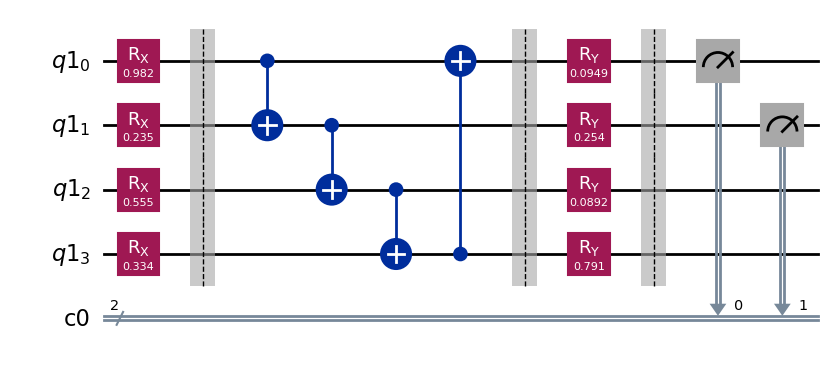

In [14]:
# entradas
theta = np.random.rand(N)
inputs = np.random.rand(N,N)[-1]
reg = bit_length(len(inputs)-1)

# construção da rede quântica
qc, c = feature_map(inputs, reg)
qc = variational_circuit(qc, theta, inputs)
qc = measure(qc, reg)

# imagem da rede quântica
qc.draw('mpl')

### Camada Quântica (

In [109]:
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, bit_length_response, shots=1E4, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.bit_length_response = bit_length_response
        self.shots = shots

    def build(self, input_shape):
        self.N = input_shape[-1]
        self.n_response = bit_length(self.bit_length_response) # self.bit_length_response
        self.theta = self.add_weight(name='theta', shape=(self.N,), initializer='random_normal', trainable=True)

    def call(self, inputs):
        print(f"Inputs: {inputs}")
        if tf.executing_eagerly():
            qc, cReg = feature_map(inputs, self.bit_length_response)
            qc = variational_circuit(qc, self.theta, inputs)
    
            for i in range(self.bit_length_response):
                qc.measure(i, cReg[i])
    
            results = AerSimulator().run(qc, shots=self.shots, memory=True).result()
            counts = results.get_counts(qc)
    
            stats = {}
            for key, value in counts.items():
                stats[binary2int(key)] = value / self.shots
    
            ordened_stats = sorted(stats, key=stats.get)
    
            ordened_results = []
            for key in ordened_stats:
                ordened_results.append(stats[key])
    
            max_key, max_value = max_value(ordened_stats)
    
            print(f"Key: {max_key}")
            return max_key

        return inputs

    def get_config(self):
        config = super(QuantumLayer, self).get_config()
        config.update({
            'bit_length_response': self.bit_length_response,
            'shots': self.shots,
        })
        return config
        

In [110]:
# Exemplo de uso da camada personalizada em um modelo
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N, N)),
    tf.keras.layers.Flatten(input_shape=(N, N)),
    tf.keras.layers.Dense(N, activation='relu'),
    QuantumLayer(N),
    tf.keras.layers.Dense(N+1)
])

Inputs: Tensor("Placeholder:0", shape=(None, 4), dtype=float32)


TypeError: Exception encountered when calling QuantumLayer.call().

[1m'SymbolicTensor' object cannot be interpreted as an integer[0m

Arguments received by QuantumLayer.call():
  • args=('<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_96>',)
  • kwargs=<class 'inspect._empty'>

In [55]:
model.build()

In [56]:
#### Compilando o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Plotar grafico de Épocas x Acurácia

In [57]:
epochs = 50

Epoch 1/50
Inputs: Tensor("sequential_6_1/dense_8_1/Relu:0", shape=(None, 4), dtype=float32)
Inputs: Tensor("sequential_6_1/dense_8_1/Relu:0", shape=(None, 4), dtype=float32)
 1/19 ━━━━━━━━━━━━━━━━━━━━ 11s 649ms/step - accuracy: 0.1250 - loss: 2.0168Inputs: Tensor("sequential_6_1/dense_8_1/Relu:0", shape=(None, 4), dtype=float32)
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1698 - loss: 1.8604 - val_accuracy: 0.0000e+00 - val_loss: 2.9329
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2345 - loss: 1.7326 - val_accuracy: 0.0000e+00 - val_loss: 3.0451
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2994 - loss: 1.5929 - val_accuracy: 0.0000e+00 - val_loss: 3.1418
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3609 - loss: 1.4981 - val_accuracy: 0.0000e+00 - val_loss: 3.2378
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4010 - loss: 1.4199 - val_accuracy: 0.0000e+00 - val_loss: 3.3190
Epoch 6/50
19/19 ━━━━━━━━━━━━

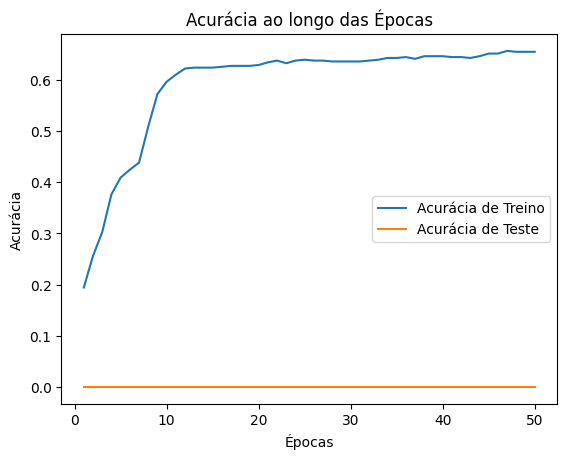

In [58]:
import matplotlib.pyplot as plt

# Treinando o modelo e salvando o histórico
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

# Obtendo as métricas de acurácia do histórico
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Construindo o gráfico
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Acurácia de Treino')
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Acurácia de Teste')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Acurácia ao longo das Épocas')
plt.legend()
plt.show()
